# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact
from IPython.display import clear_output

import torch
from torchsummary import summary
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn
import torch.nn as nn

from data.CanopyDataset import CanopyDataset
from models.SEResNet import SEResNet

# Load dataset

In [2]:
train_dataset = CanopyDataset(split='train')
train_dataset.save_statistics(stats_file="../data/train_stats.dat")
val_dataset = CanopyDataset(split='validation', stats_file="../data/train_stats.dat")

In [3]:
%matplotlib inline

# Plot examples from the dataset
@interact(train_idx=range(len(val_dataset)))
def plot_sample(train_idx=0):
    clear_output(wait=True)
    train_img, train_label, mask = val_dataset[train_idx]
    train_img = train_img.numpy()
    train_img = np.transpose(train_img, (1, 2, 0))  # (C, H, W) -> (H, W, C)
    train_label = train_label.numpy()

    print(train_img.shape)

    # Plot all 12 bands
    f, axs = plt.subplots(2, 6, figsize=(14, 4), constrained_layout=True)
    axs = axs.flatten()

    for i in range(12):
        axs[i].imshow(train_img[:, :, i])
        axs[i].set_title(f"Band {i}, index {train_idx}")

    # Plot label image
    f, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(train_label)
    ax.set_title("Label image")

    plt.show()


interactive(children=(Dropdown(description='train_idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

# Init model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SEResNet().to(device)
summary(model, input_size=(12, 32, 32))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,308
├─Sequential: 1-2                        --
|    └─ResidualBlock: 2-1                --
|    |    └─Conv2d: 3-1                  6,976
|    |    └─GroupNorm: 3-2               128
|    |    └─Conv2d: 3-3                  36,928
|    |    └─GroupNorm: 3-4               128
|    |    └─SEBlock: 3-5                 1,096
|    |    └─SiLU: 3-6                    --
|    |    └─Conv2d: 3-7                  832
|    └─ResidualBlock: 2-2                --
|    |    └─Conv2d: 3-8                  73,856
|    |    └─GroupNorm: 3-9               256
|    |    └─Conv2d: 3-10                 147,584
|    |    └─GroupNorm: 3-11              256
|    |    └─SEBlock: 3-12                4,240
|    |    └─SiLU: 3-13                   --
|    |    └─Conv2d: 3-14                 8,320
|    └─AdaptiveAvgPool2d: 2-3            --
|    └─Conv2d: 2-4                       8,256
├─Sequential: 1-3                  

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,308
├─Sequential: 1-2                        --
|    └─ResidualBlock: 2-1                --
|    |    └─Conv2d: 3-1                  6,976
|    |    └─GroupNorm: 3-2               128
|    |    └─Conv2d: 3-3                  36,928
|    |    └─GroupNorm: 3-4               128
|    |    └─SEBlock: 3-5                 1,096
|    |    └─SiLU: 3-6                    --
|    |    └─Conv2d: 3-7                  832
|    └─ResidualBlock: 2-2                --
|    |    └─Conv2d: 3-8                  73,856
|    |    └─GroupNorm: 3-9               256
|    |    └─Conv2d: 3-10                 147,584
|    |    └─GroupNorm: 3-11              256
|    |    └─SEBlock: 3-12                4,240
|    |    └─SiLU: 3-13                   --
|    |    └─Conv2d: 3-14                 8,320
|    └─AdaptiveAvgPool2d: 2-3            --
|    └─Conv2d: 2-4                       8,256
├─Sequential: 1-3                  

# Training

### Utility functions

In [5]:
def plot_validation_results(labels, outputs, num_images=6):
    num_images = min(num_images, labels.shape[0])
    fig, axes = plt.subplots(2, num_images, figsize=(4 * num_images, 6)) 
    
    combined_min = min(labels.min().cpu().numpy(), outputs.min().cpu().detach().numpy())
    combined_max = max(labels.max().cpu().numpy(), outputs.max().cpu().detach().numpy())

    for i in range(num_images):
        label_normalized = (labels[i].cpu().numpy() - combined_min) / (combined_max - combined_min)
        output_normalized = (outputs[i].cpu().detach().numpy() - combined_min) / (combined_max - combined_min)

        # Plot label (first row)
        axes[0, i].imshow(label_normalized, cmap='jet')
        axes[0, i].set_title(f"Label {i}")
        axes[0, i].axis('off')

        # Plot output (second row)
        axes[1, i].imshow(output_normalized, cmap='jet')
        axes[1, i].set_title(f"Output {i}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

class MaskedMSELoss(nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, prediction, target, mask):
        loss = (mask * (prediction - target) ** 2).sum() / mask.sum()
        return loss

### Init params

In [6]:
criterion = MaskedMSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-7)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

num_epochs = 20
train_losses = []
val_losses = []
best_val_loss = float("inf")
best_model_path = "best_model.pth"

### Training loop

Epoch [1/60], Step [100/739], Loss: 0.3619
Epoch [1/60], Step [200/739], Loss: 0.3564
Epoch [1/60], Step [300/739], Loss: 0.3150
Epoch [1/60], Step [400/739], Loss: 0.3149
Epoch [1/60], Step [500/739], Loss: 0.3519
Epoch [1/60], Step [600/739], Loss: 0.3080
Epoch [1/60], Step [700/739], Loss: 0.3282


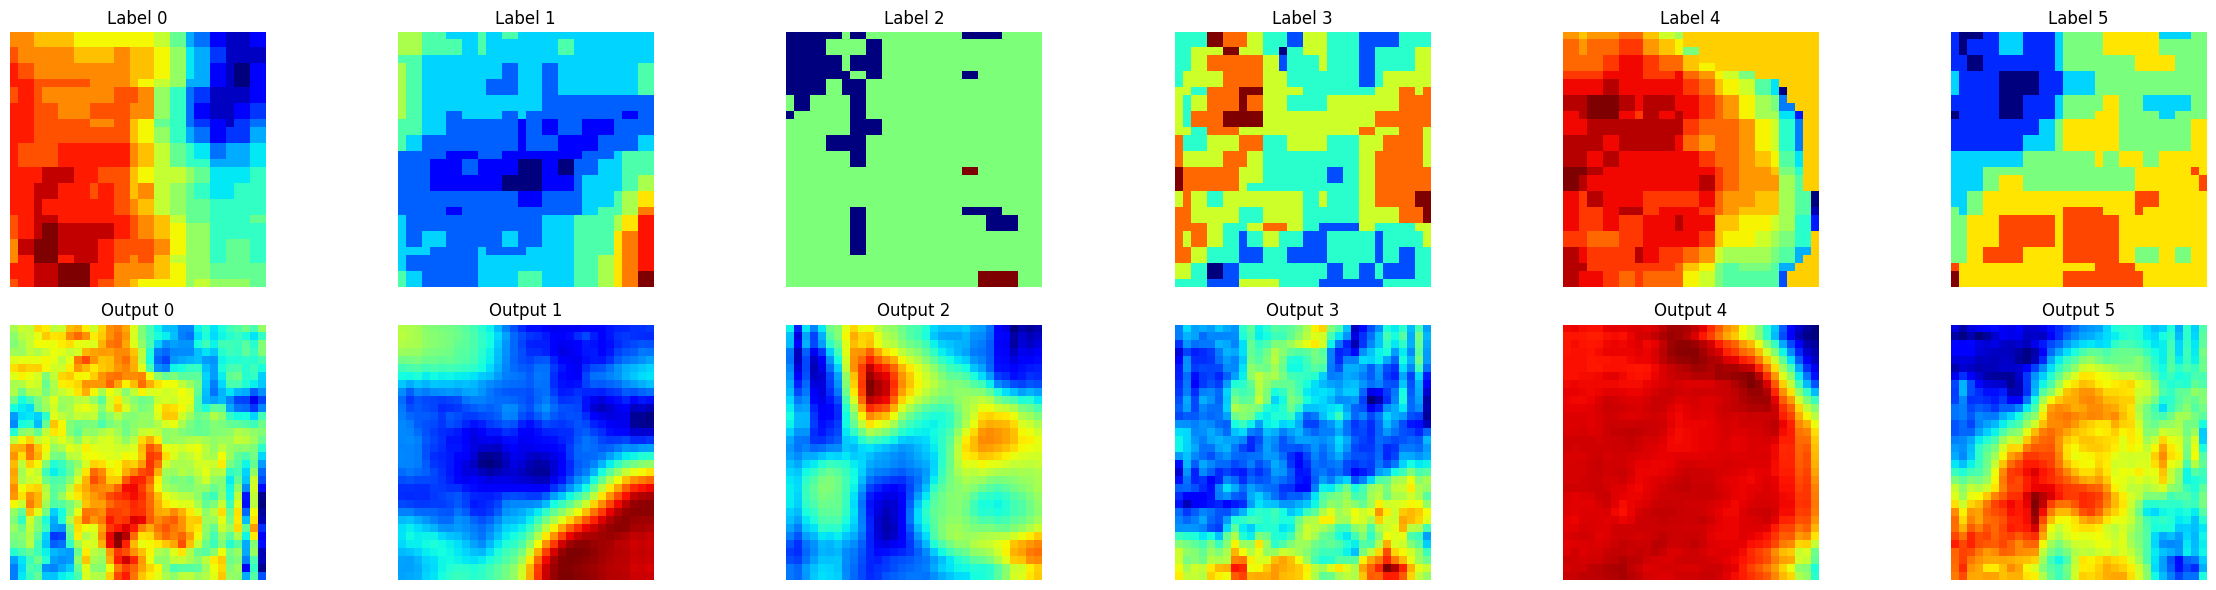

Saved Best Model (Validation Loss: 0.5061)
Epoch [1/60], Train Loss: 0.3344, Validation Loss: 0.5061
Epoch [2/60], Step [100/739], Loss: 0.3087
Epoch [2/60], Step [200/739], Loss: 0.3020
Epoch [2/60], Step [300/739], Loss: 0.3104
Epoch [2/60], Step [400/739], Loss: 0.3077
Epoch [2/60], Step [500/739], Loss: 0.3045
Epoch [2/60], Step [600/739], Loss: 0.2771
Epoch [2/60], Step [700/739], Loss: 0.2685


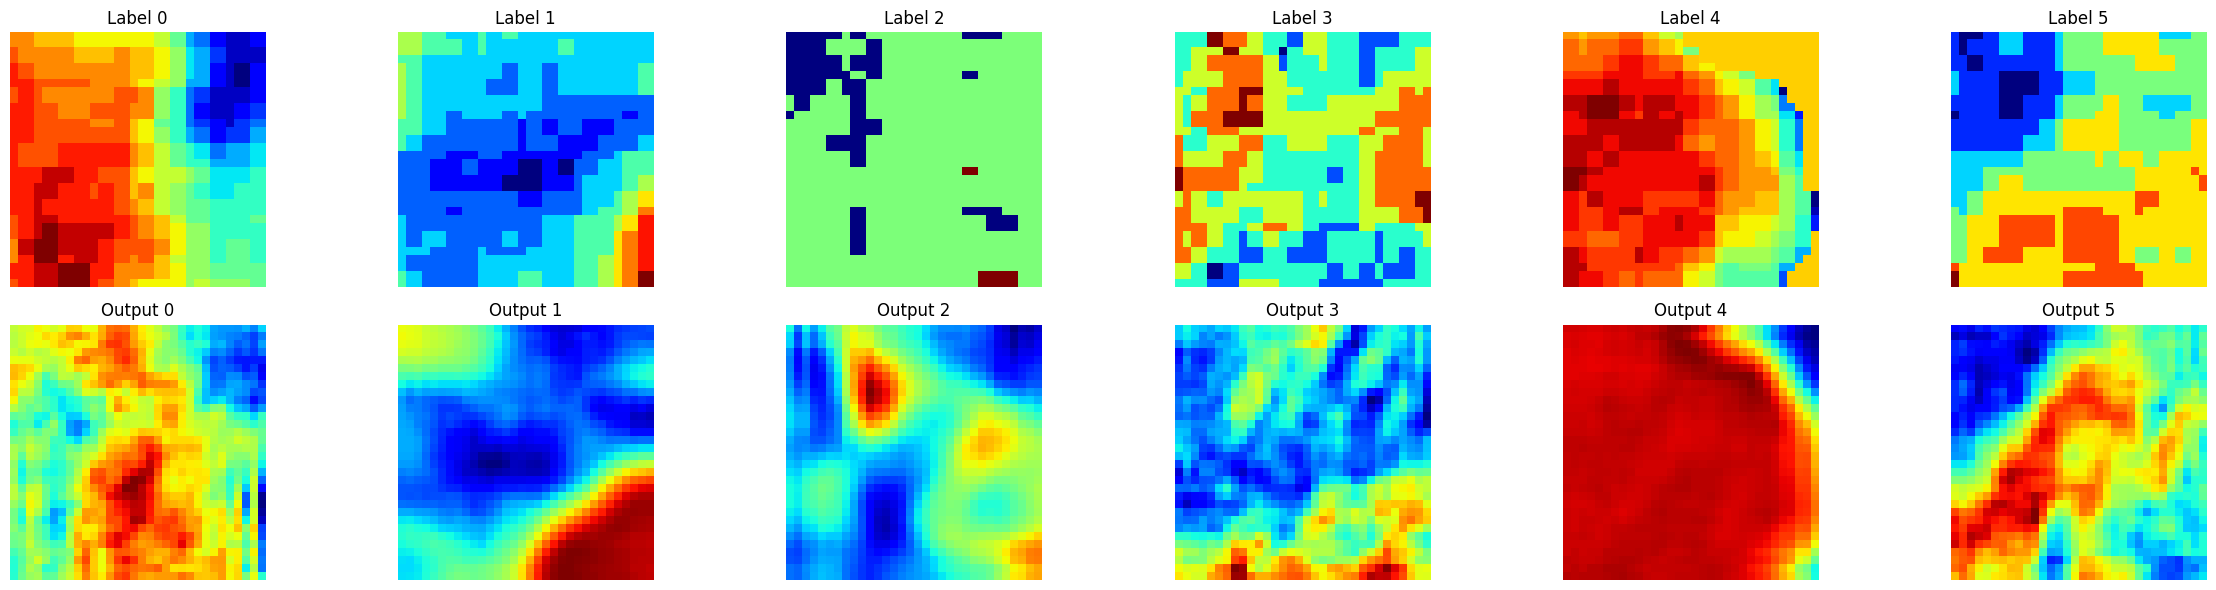

Saved Best Model (Validation Loss: 0.4659)
Epoch [2/60], Train Loss: 0.2975, Validation Loss: 0.4659
Epoch [3/60], Step [100/739], Loss: 0.2816
Epoch [3/60], Step [200/739], Loss: 0.2800
Epoch [3/60], Step [300/739], Loss: 0.2699
Epoch [3/60], Step [400/739], Loss: 0.2768
Epoch [3/60], Step [500/739], Loss: 0.2861


KeyboardInterrupt: 

In [9]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_train_loss = 0.0
    num_batches = 0

    for idx, (images, labels, mask) in enumerate(train_loader):
        images = images.to(torch.float32).to(device)
        labels = labels.to(torch.float32).to(device)
        mask = mask.to(torch.float32).to(device)

        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels, mask)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_train_loss += loss.item()
        num_batches += 1

        if (idx + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0

    avg_train_loss = total_train_loss / num_batches
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()  
    val_loss = 0.0
    with torch.no_grad():
        for idx, (images, labels, mask) in enumerate(val_loader):
            images = images.to(torch.float32).to(device)
            labels = labels.to(torch.float32).to(device)
            mask = mask.to(torch.float32).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels, mask)
            val_loss += loss.item()

            if idx == 0:
                plot_validation_results(labels, outputs, num_images=6)

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Step the scheduler
    scheduler.step(avg_val_loss)

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved Best Model (Validation Loss: {best_val_loss:.4f})")

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


### Plot loss

In [11]:
# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="x")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()
# TODO savefig

NameError: name 'train_losses' is not defined

<Figure size 1000x500 with 0 Axes>